# 4b. Predict emergency demand

This notebook demonstrates the full implementation in code. I show how we used these building blocks in our application at University College London Hospital (UCLH) to predict emergency demand for beds, by service, over the next 8 hours.

The notebook first loads data and trains models. This code is repeated from previous notebooks. It then demonstrates the logic used to generate predictions for real-time inference.

The predictions combine two sources of demand:

**Section 1: Patients currently in the ED** - We predict the probability that each patient will be admitted, which service they will be admitted to, and whether they will be admitted within the prediction window. This section includes **s step-through in Python** demonstrating the real-time inference steps, showing how predictions are generated for current ED patients by combining admission probabilities, specialty assignments, and admission window probabilities.

**Section 2: Patients yet to arrive** - We predict the expected number of patients who will arrive at the ED and need admission within the prediction window, by service. Again, this section includes **s step-through in Python** demonstrating the real-time inference steps.

**Section 3: Helper functions for predicting real-time inference** - I show two approaches provided in `patientflow` that move the logic shown above into the package.

- **The current approach at UCLH**, which encapsulates the logic from the step-through using a function called `build_prediction_inputs`. By using data classes (such as `ServicePredictionInputs` and `FlowInputs`), this approach provides a structured, type-safe way to organise prediction inputs.
- **The legacy approach** (using `create_predictions`), which was the original implementation at UCLH and is maintained for backward compatibility.

I show two approaches for predicting demand for beds within the prediction window:

- **Aspirational approach** - Demand for beds, assuming that ED four-hour targets are met. This uses parametric curves based on specified ED performance targets. (**Sections 1-3**)

- **Informed by past performance** - Demand for beds assuming that the ED performs as it has in the past, using empirical survival curves to calculate the probability of admission within the prediction window. (**Section 4**)

## Load data and prepare for model training

I'm going to use real patient data from UCLH to demonstrate the implementation. 

You can request the datasets that are used here on [Zenodo](https://zenodo.org/records/14866057). Alternatively you can use the synthetic data that has been created from the distributions of real patient data. If you don't have the public data, change the argument in the cell below from `data_folder_name='data-public'` to `data_folder_name='data-synthetic'`.

The parameters used in training and inference are set in config.json in the root of the repository and loaded by `load_config_file()`

In [1]:
# Reload functions every time
%load_ext autoreload 
%autoreload 

In [2]:
import pandas as pd
from patientflow.load import load_data, set_project_root
from patientflow.load import set_file_paths
from patientflow.prepare import create_temporal_splits
from patientflow.load import load_config_file

# set file paths
project_root = set_project_root()
data_folder_name = 'data-public'
data_file_path = project_root / data_folder_name

data_file_path, media_file_path, model_file_path, config_path = set_file_paths(
    project_root, 
    data_folder_name=data_folder_name,
    config_file = 'config.yaml', verbose=False)


# load ED snapshots data
ed_visits = load_data(data_file_path, 
                    file_name='ed_visits.csv', 
                    index_column = 'snapshot_id',
                    sort_columns = ["visit_number", "snapshot_date", "prediction_time"], 
                    eval_columns = ["prediction_time", "consultation_sequence", "final_sequence"])
ed_visits.snapshot_date = pd.to_datetime(ed_visits.snapshot_date).dt.date
ed_visits.elapsed_los = pd.to_timedelta(ed_visits.elapsed_los, 'seconds')

# load data on inpatient arrivals
inpatient_arrivals = inpatient_arrivals = load_data(data_file_path, 
                    file_name='inpatient_arrivals.csv')
inpatient_arrivals['arrival_datetime'] = pd.to_datetime(inpatient_arrivals['arrival_datetime'], utc = True)


#  Set modelling parameters
params = load_config_file(config_path)

start_training_set, start_validation_set, start_test_set, end_test_set = params["start_training_set"], params["start_validation_set"], params["start_test_set"], params["end_test_set"]

print(f'\nTraining set starts {start_training_set} and ends on {start_validation_set - pd.Timedelta(days=1)} inclusive')
print(f'Validation set starts on {start_validation_set} and ends on {start_test_set - pd.Timedelta(days=1)} inclusive' )
print(f'Test set starts on {start_test_set} and ends on {end_test_set- pd.Timedelta(days=1)} inclusive' )

# Split data into training, validation and test sets
train_visits_df, valid_visits_df, test_visits_df = create_temporal_splits(
    ed_visits,
    start_training_set,
    start_validation_set,
    start_test_set,
    end_test_set,
    col_name="snapshot_date",
)

train_inpatient_arrivals_df, _, _ = create_temporal_splits(
    inpatient_arrivals,
    start_training_set,
    start_validation_set,
    start_test_set,
    end_test_set,
    col_name="arrival_datetime",
)

Inferred project root: /Users/zellaking/Repos/patientflow

Training set starts 2031-03-01 and ends on 2031-08-31 inclusive
Validation set starts on 2031-09-01 and ends on 2031-09-30 inclusive
Test set starts on 2031-10-01 and ends on 2031-12-31 inclusive
Split sizes: [62071, 10415, 29134]
Split sizes: [7716, 1285, 3898]


The data has been prepared as a series of snapshots of each patient's data at five moments during the day. These five moments are the times when the bed managers wish to receive predictive models of emergency demand. If a patient arrives in the ED at 4 am, and leaves at 11 am, they will be represented in the 06:00 and 09:30 prediction times. Everything known about a patient is included up until that moment is included in that snapshot.

The predition times are presented as tuples in the form (hour, minute). 

From the output below we can see that there are most snapshots at 15:30 - since afternoons are typically the busiest times in the ED - and least at 06:00. 

In [3]:
print("\nTimes of day at which predictions will be made")
print(ed_visits.prediction_time.unique())


Times of day at which predictions will be made
[(22, 0) (15, 30) (6, 0) (12, 0) (9, 30)]


In [4]:
print("\nNumber of observations for each prediction time")
print(ed_visits.prediction_time.value_counts())


Number of observations for each prediction time
prediction_time
(15, 30)    35310
(12, 0)     29942
(22, 0)     28457
(9, 30)     17642
(6, 0)      11984
Name: count, dtype: int64



## Train models

### Train models for patients currently in the ED

In [5]:

from patientflow.train.classifiers import train_classifier
from patientflow.load import get_model_key

grid = {"n_estimators": [30], "subsample": [0.7], "colsample_bytree": [0.7]} # simple grid for expediency

exclude_from_training_data = [ 'snapshot_date', 'prediction_time','visit_number', 'consultation_sequence', 'specialty', 'final_sequence', ]

ordinal_mappings = {
    "latest_acvpu": ["A", "C", "V", "P", "U"],
    "latest_obs_manchester_triage_acuity": [
        "Blue",
        "Green",
        "Yellow",
        "Orange",
        "Red",
    ],
    "latest_obs_objective_pain_score": [
        "Nil",
        "Mild",
        "Moderate",
        "Severe\\E\\Very Severe",
    ],
    "latest_obs_level_of_consciousness": ["A", "C", "V", "P", "U"],
}

# create a dictionary to store the trained models
admissions_models = {}
model_name = 'admissions'

# Loop through each prediction time
for prediction_time in ed_visits.prediction_time.unique():
    print(f"Training model for {prediction_time}")
    model = train_classifier(
        train_visits=train_visits_df,
        valid_visits=valid_visits_df,
        test_visits=test_visits_df,
        grid=grid,
        exclude_from_training_data=exclude_from_training_data,
        ordinal_mappings=ordinal_mappings,
        prediction_time=prediction_time,
        visit_col="visit_number",
        calibrate_probabilities=True,
        calibration_method="isotonic",
        use_balanced_training=True,
    )
    model_key = get_model_key(model_name, prediction_time)
    
    admissions_models[model_key] = model

Training model for (22, 0)
Training model for (15, 30)
Training model for (6, 0)
Training model for (12, 0)
Training model for (9, 30)



The `SequencePredictor` is used to train the probability of each patient being admitted to a specialty, if admitted. As shown in the previous notebook, ordered sequences of consult requests (also known as referrals to service) are used to train this model. 

Here a `MultieSubgroupPredictor` wrapper is applied. This will train multiple instances of the `SequencePredictor`, for subgroups of patients. We will train the model to handle paediatric patients as special cases; at UCLH, it is assumed that all patients under 18 on arrival will be admitted to a paediatric specialty.

In [6]:
from patientflow.predictors.sequence_to_outcome_predictor import SequenceToOutcomePredictor
from patientflow.predictors.subgroup_predictor import MultiSubgroupPredictor

def create_subgroup_functions_from_age_group():
    """Create subgroup functions that work with age_group categorical variable."""
    
    def is_paediatric(row):
        return row.get("age_group") == "0-17"
    
    def is_adult(row):
        # All non-paediatric patients are adults
        return row.get("age_group") != "0-17"
    
    return {
        "paediatric": is_paediatric,
        "adult": is_adult,
    }

subgroup_functions = create_subgroup_functions_from_age_group()

spec_model = MultiSubgroupPredictor(
    subgroup_functions=subgroup_functions,
    base_predictor_class=SequenceToOutcomePredictor,
    input_var="consultation_sequence",
    grouping_var="final_sequence",
    outcome_var="specialty",
    min_samples=50,  # Minimum samples required per subgroup
)
spec_model = spec_model.fit(train_visits_df)

### Train models for patients yet to arrive

As we are predicting by clinical area we will want the predicted bed counts for patients yet to arrive to be calculated for each separately. A dictionary, here called `specialty_filters`, is used to tell the `ParametricIncomingAdmissionPredictor` which column contains the outcome we want to split by. 

In [7]:
from patientflow.predictors.incoming_admission_predictors import ParametricIncomingAdmissionPredictor
from datetime import timedelta

# set the ED targets
x1, y1, x2, y2 = params["x1"], params["y1"], params["x2"], params["y2"]
prediction_window = timedelta(minutes=params["prediction_window"])
yta_time_interval = timedelta(minutes=params["yta_time_interval"])

specialty_filters = filters={
    'medical': {'specialty': 'medical'},
    'surgical': {'specialty': 'surgical'},
    'haem/onc': {'specialty': 'haem/onc'},
    'paediatric': {'specialty': 'paediatric'}
    }
yta_model_by_spec =  ParametricIncomingAdmissionPredictor(filters = specialty_filters, verbose=False)

# calculate the number of days between the start of the training and validation sets; 
# this is used to calculate daily arrival rates
num_days = (start_validation_set - start_training_set).days

if 'arrival_datetime' in train_inpatient_arrivals_df.columns:
    train_inpatient_arrivals_df.set_index('arrival_datetime', inplace=True)

yta_model_by_spec =yta_model_by_spec.fit(train_inpatient_arrivals_df, 
              prediction_window=prediction_window, 
              yta_time_interval=yta_time_interval, 
              prediction_times=ed_visits.prediction_time.unique(), 
              num_days=num_days )

## 1. Make predictions for the group of patients currently in the ED

We now have models trained that we can use to create predicted probability distributions. Here is a detailed step-through of how to use those models to generate predictions at a particular moment. 

To illustrate, I'll pick a random prediction date and time from the test set. 

In [8]:
from patientflow.viz.utils import format_prediction_time
from patientflow.prepare import prepare_patient_snapshots, prepare_group_snapshot_dict

# Set seed
import numpy as np
np.random.seed(42)

# Randomly pick a prediction moment to do inference on
random_row = test_visits_df.sample(n=1)
random_prediction_time = random_row.prediction_time.values[0]
random_prediction_date = random_row.snapshot_date.values[0]

prediction_snapshots = ed_visits[(ed_visits.prediction_time == random_prediction_time) & \
            (ed_visits.snapshot_date == random_prediction_date)]

print(f'Number of adult patients in the ED at {format_prediction_time(random_prediction_time)} on {random_prediction_date}:',
      f'{len(prediction_snapshots[prediction_snapshots.age_group != "0-17"])}')

print(f'Number of patients under the age of 18 in the ED at {format_prediction_time(random_prediction_time)} on {random_prediction_date}:',
      f'{len(prediction_snapshots[prediction_snapshots.age_group == "0-17"])}')

# format patient snapshots for input into the admissions model
X_test, y_test = prepare_patient_snapshots(
    df=prediction_snapshots, 
    prediction_time=random_prediction_time, 
    single_snapshot_per_visit=False,
    visit_col='visit_number'
)

# retrieve the admissions model for the prediction time
admission_model = admissions_models[get_model_key(model_name, random_prediction_time)]

# prepare group snapshots dict to indicate which patients comprise the group we want to predict for
group_snapshots_dict = prepare_group_snapshot_dict(
    prediction_snapshots
    )

Number of adult patients in the ED at 22:00 on 2031-10-09: 69
Number of patients under the age of 18 in the ED at 22:00 on 2031-10-09: 10


The predicted bed counts for patients in the ED take three probabilities into account for each patient snapshots: 

* probability of being admitted after the ED has ended
* probability of being admitted to each specialty, if admitted
* probability of being admitted within the prediction window, taking into account how much time has elapsed since the patient arrived, and the stated ED targets

To set the ED targets, we use the parameters set in the config file. The config file also specifies the length of the prediction, and (for use later) the length of the discrete intervals used to calculate arrival rates for yet-to-arrive patients.

In [9]:
# set the ED targets
x1, y1, x2, y2 = params["x1"], params["y1"], params["x2"], params["y2"]
prediction_window = timedelta(minutes=params["prediction_window"])
yta_time_interval = timedelta(minutes=params["yta_time_interval"])

In the cell below I first calculate `prob_admission_in_window`, the probability of being admitted within the prediction window, given the elapsed time since each patient arrived, and the specified ED targets. 

Then, for each patient snapshot, I calculate 'prob_admission_to_specialty`, the probability of admission to specialty if admitted, by applying the specialty model trained earlier. 

These two probabilities for each patient snapshot are multiplied and the result passed to `get_prob_dist` function as weights. 

In [10]:
from patientflow.viz.probability_distribution import plot_prob_dist
from patientflow.aggregate import get_prob_dist, model_input_to_pred_proba
from patientflow.calculate.admission_in_prediction_window import calculate_probability
from datetime import timedelta


# Extract pipeline if model is a TrainedClassifier
if hasattr(admission_model, "calibrated_pipeline") and admission_model.calibrated_pipeline is not None:
    ed_pipeline = admission_model.calibrated_pipeline
elif hasattr(admission_model, "pipeline"):
    ed_pipeline = admission_model.pipeline
else:
    ed_pipeline = admission_model

# Get probability of admission after ED
prob_admission_after_ed = model_input_to_pred_proba(prediction_snapshots, ed_pipeline)


# Calculate probability of admission within prediction window using ED targets
prob_admission_in_window = prediction_snapshots.apply(
    lambda row: calculate_probability(
        elapsed_los = row["elapsed_los"], 
        prediction_window = prediction_window,
        x1 = x1,
        y1 = y1,
        x2 = x2,
        y2 = y2
    ),
    axis=1,
)


With these probabilities prepared, I now iterate through the specialties to generate predictions for each in turn, and plot them in the charts shown.

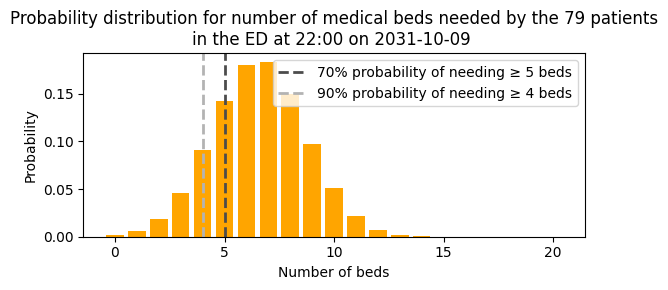

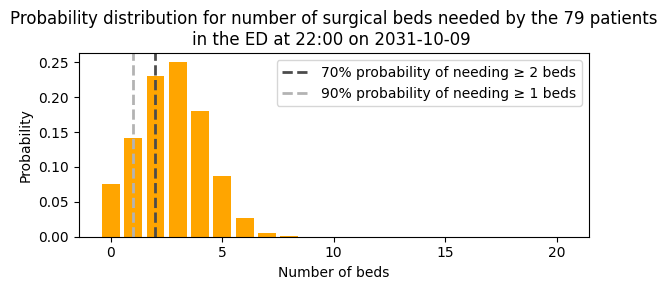

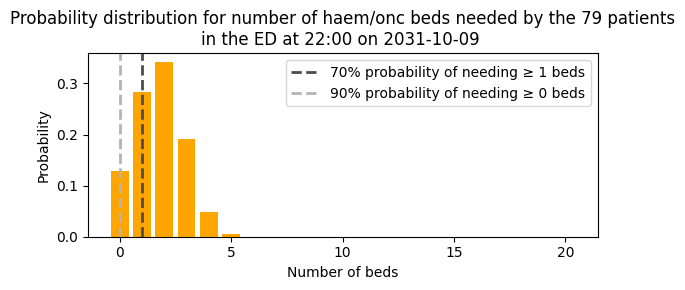

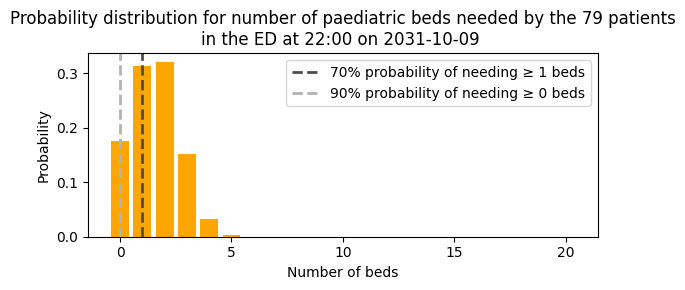

In [11]:

# Get specialty probabilities for all patients 
specialty_probs_all = spec_model.predict_dataframe(prediction_snapshots)

# generate and plot predicted bed count distributions for each specialty
for specialty in ['medical', 'surgical', 'haem/onc', 'paediatric']:

# Use predict_dataframe for MultiSubgroupPredictor (handles subgroup routing automatically)
    # Extract probability for this specialty from the pre-computed dictionaries
    prob_admission_to_specialty = specialty_probs_all.apply(
        lambda d: d.get(specialty, 0.0) if isinstance(d, dict) else 0.0
    )
        
    # Filter patients: only process those with non-zero specialty probability
    non_zero_mask = prob_admission_to_specialty > 0.0
    filtered_indices = prediction_snapshots[non_zero_mask].index
    
    if len(filtered_indices) == 0:
        # No patients for this specialty - create zero PMF
        prob_dist_dict = {
            random_prediction_date: {
                'agg_predicted': pd.DataFrame({"agg_proba": [1.0]}, index=[0]),
                'agg_observed': 0
            }
        }
    else:
        # Filter all probabilities and data for this specialty
        filtered_prob_admission_after_ed = prob_admission_after_ed.loc[filtered_indices]
        filtered_prob_admission_to_specialty = prob_admission_to_specialty.loc[filtered_indices]
        filtered_prob_admission_in_window = prob_admission_in_window.loc[filtered_indices]
        
        # Compute weights for filtered patients
        filtered_weights = (
            filtered_prob_admission_to_specialty * filtered_prob_admission_in_window
        )
        
        # Create filtered group_snapshots_dict for this specialty
        filtered_group_snapshots_dict = {
            random_prediction_date: [idx for idx in group_snapshots_dict[random_prediction_date] 
                                   if idx in filtered_indices]
        }
        
        # Get probability distribution using filtered data
        prob_dist_dict = get_prob_dist(
            filtered_group_snapshots_dict, 
            X_test.loc[filtered_indices], 
            y_test.loc[filtered_indices], 
            admission_model, 
            weights=filtered_weights
        )

    title = (
        f'Probability distribution for number of {specialty} beds needed by the '
        f'{len(prediction_snapshots)} patients\n'
        f'in the ED at {format_prediction_time(random_prediction_time)} '
        f'on {random_prediction_date} '
    )
    plot_prob_dist(
        prob_dist_dict[random_prediction_date]['agg_predicted'], 
        title, 
        include_titles=True, 
        truncate_at_beds=20,
        probability_levels=[0.7, 0.9],
        show_probability_thresholds=True, 
        bar_colour='orange'
    )

## 2. Make predictions for patients yet-to-arrive to the ED who will need admission

The trained yet-to-arrive model generates the same distribution for each prediction time, irrespective of day of week, for each specialty. Passing the randomly chosen prediction time, for each specialty, will return the required distributions.


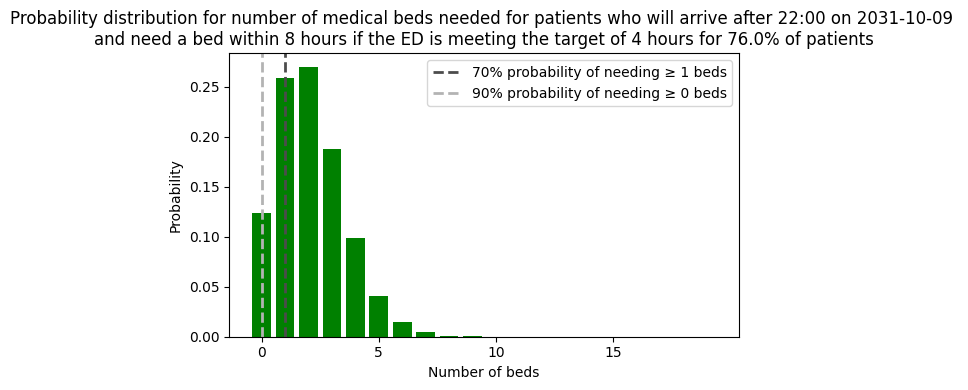

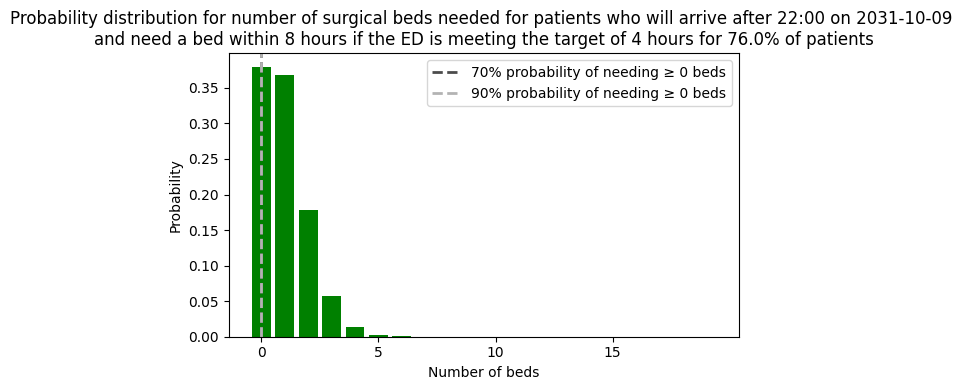

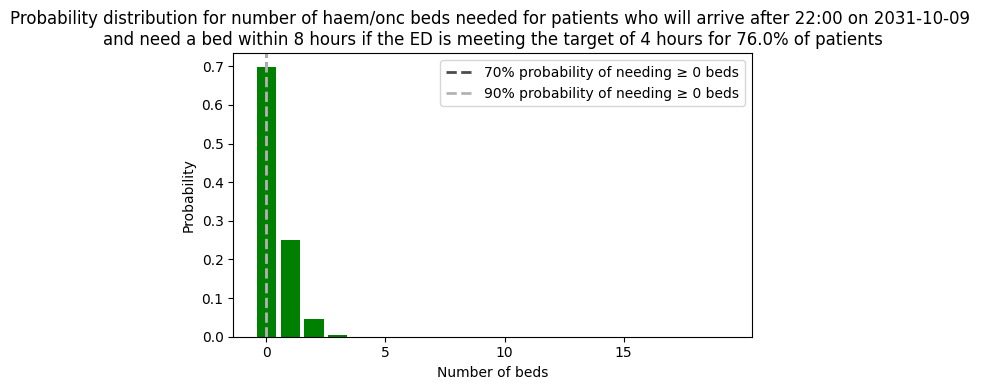

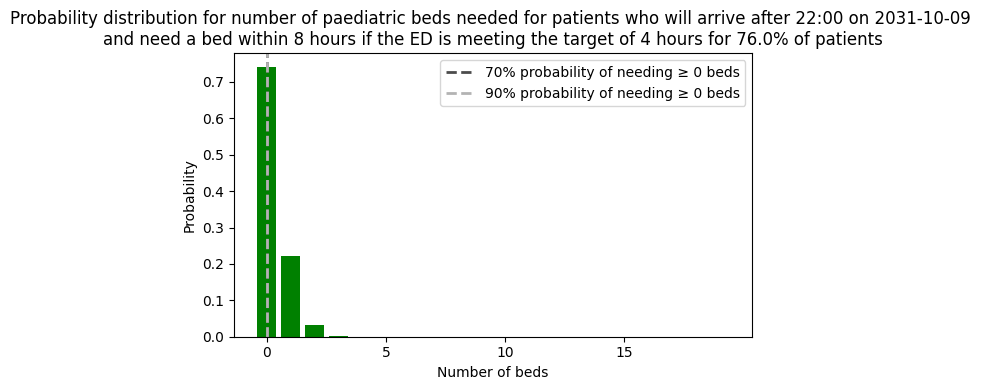

In [12]:
for specialty in [ 'medical', 'surgical', 'haem/onc', 'paediatric']:

    prediction_context = {
        specialty: {
            'prediction_time': random_prediction_time
        }
    }

    weighted_poisson_prediction = yta_model_by_spec.predict(prediction_context, x1=x1, y1=y1, x2=x2, y2=y2)
    title = (
    f'Probability distribution for number of {specialty} beds needed for patients '
    f'who will arrive after {format_prediction_time((random_prediction_time))} on {random_prediction_date} '
    f'\nand need a bed within 8 hours '
    f'if the ED is meeting the target of {int(x1)} hours for {y1*100}% of patients'
)
    plot_prob_dist(weighted_poisson_prediction[specialty], title,  
        include_titles=True,
        truncate_at_beds=20,
        probability_levels=[0.7,0.9],
        show_probability_thresholds=True,
        figsize=(6, 4) , bar_colour='green')

##  3. Helper functions for predicting real-time inference

In place of the length code shown above, I show two different approaches provided in `patientflow` that move the logic shown above into the package.

- **The current approach at UCLH**, which encapsulates the logic from the step-through using a function called `build_prediction_inputs`. By using data classes (such as `ServicePredictionInputs` and `FlowInputs`), this approach provides a structured, type-safe way to organise prediction inputs that can be used with the hierarchical prediction system shown in a following notebook.
- **The legacy approach** (using `create_predictions`), which was the original implementation at UCLH and is maintained for backward compatibility.

### Current approach at UCLH - use of the `predict.service` module

To make demand predictions at a given prediction moment, we use a function from the `predict.service` module to prepare the prediction inputs (the trained models, the input data for that prediction moment, the yet-to-arrive parameters and the requested prediction window)

In [13]:
from patientflow.predict.service import build_service_data

# select the relevant ED admissions model based on the prediction time
admission_model = admissions_models[get_model_key(model_name, random_prediction_time)]

# convert elapsed_los to timedelta to ensure correct calculation of probability of admission within prediction window
prediction_snapshots_processed = prediction_snapshots.copy(deep=True)
prediction_snapshots_processed['elapsed_los'] = pd.to_timedelta(prediction_snapshots_processed['elapsed_los'], unit='s')

# generate the prediction inputs
prediction_inputs = build_service_data(
    models=(admission_model, None, spec_model, yta_model_by_spec, None, None, None),
    prediction_time=random_prediction_time,
    ed_snapshots=prediction_snapshots_processed,
    inpatient_snapshots=None,  
    specialties=specialty_filters.keys(),
    prediction_window=timedelta(hours=8),
    x1=x1, y1=y1, x2=x2, y2=y2
)


The returned object is a dictionary, with keys for each speciality. Below I show the resulting object for one of the specialties. The class has been created to handle different types of flow, including elective inflows and discharges. It contains an set of attributes that will be used to generate a prediction, including both inflows via the ED (used here), and (not used here) elective admissions, transfers and outflows. The latter group all show inflow and outflow predictions of zero patients when no models are trained. 

In [14]:
prediction_inputs['medical']

ServicePredictionInputs(service='medical')
  INFLOWS:
    Admissions from current ED               PMF[3:13]: [0.015, 0.037, 0.073, 0.119, 0.159, 0.176, 0.160, 0.120, 0.074, 0.037] (E=8.0 of 79 patients in ED)
    ED yet-to-arrive admissions              λ = 2.090
    Non-ED emergency admissions              λ = 0.000
    Elective admissions                      λ = 0.000
    Elective transfers from other services   PMF[0:1]: [1.000] (E=0.0)
    Emergency transfers from other services  PMF[0:1]: [1.000] (E=0.0)
  OUTFLOWS:
    Emergency inpatient departures           PMF[0:1]: [1.000] (E=0.0 of 0 emergency patients in service)
    Elective inpatient departures            PMF[0:1]: [1.000] (E=0.0 of 0 elective patients in service)

 The `DemandPredictor` class has also been created to handle different types of flow, including elective inflows and discharges.
 
The `FlowSelection` parameter controls what prediction output we want. Here I have specified to include patients currently in the ED and to exclude all other flows.

 The `k_sigma` parameter is used to control truncation of probability mass. It specifies the maximum level of support (maximum number of beds in our case) to return. This is useful when convolving multiple distributions. For example, we might want to combining inflows of yet-to-arrive emergency patients from different sources; if some of these flows are modelled as Poisson distributions, which are by definition unbounded, the parameter controls where they are capped.  

 We use the `DemandPredictor` to create a bundle of predictions for all the relevant flows.


In [15]:
from patientflow.predict.demand import DemandPredictor
from patientflow.predict.demand import FlowSelection 
predictor = DemandPredictor(k_sigma=8.0)

current_ed_bundle = predictor.predict_service(
    inputs=prediction_inputs['medical'],
   flow_selection=FlowSelection.custom(
        include_ed_current=True, # only include patients currently in the ED
        include_ed_yta=False,
        include_non_ed_yta=False,
        include_elective_yta=False,
        include_transfers_in=False,
        include_departures=False,  
        cohort="emergency"
    ))


To view the consitutent elements of the bundle, we can print it to get pretty output. A pmf range of 10 values is included in the printed output, centred around the mode. The output also records which flows were included. 


In [16]:
print(current_ed_bundle)

PredictionBundle(service: medical)
  Arrivals:    PMF[3:13]: [0.015, 0.037, 0.073, 0.119, 0.159, 0.176, 0.160, 0.120, 0.074, 0.037] (E=8.0)
  Departures:  PMF[0:1]: [1.000] (E=0.0)
  Net flow:    PMF[3:13]: [0.015, 0.037, 0.073, 0.119, 0.159, 0.176, 0.160, 0.120, 0.074, 0.037] (E=8.0)
  Flows:       selection cohort=emergency inflows(ed_current=True, ed_yta=False, non_ed_yta=False, elective_yta=False, transfers_in=False) outflows(departures=False)


From the bundle, we can extract a probability distribution for the number of beds needed for patients currently in the ED. We can view the expectation, or view the percentiles of the distribution as shown below.

In [17]:
print('For patients currently in the ED:\n')
print(f'Most likely number of beds needed for the medical specialty: {current_ed_bundle.arrivals.mode}')
print(f"Need at least {current_ed_bundle.arrivals.min_beds_with_probability(0.9)} beds with 90% probability")
print(f"Need at least {current_ed_bundle.arrivals.min_beds_with_probability(0.7)} beds with 70% probability")

For patients currently in the ED:

Most likely number of beds needed for the medical specialty: 8
Need at least 5 beds with 90% probability
Need at least 7 beds with 70% probability


To derive the yet-to-arrive predictions, we can set the FlowSelection accordingly. 

In [18]:
yet_to_arrive_to_ed_bundle = predictor.predict_service(
    inputs=prediction_inputs['medical'],
   flow_selection=FlowSelection.custom(
        include_ed_current=False,
        include_ed_yta=True, # only include yet-to-arrive patients
        include_non_ed_yta=False,
        include_elective_yta=False,
        include_transfers_in=False,
        include_departures=False,  
        cohort="emergency"
    ))

In [19]:
print('For patients yet-to-arrive to the ED:\n')
print(f'Most likely number of beds needed for the medical specialty: {yet_to_arrive_to_ed_bundle.arrivals.mode}')
print(f"Need at least {yet_to_arrive_to_ed_bundle.arrivals.min_beds_with_probability(0.9)} beds with 90% probability")
print(f"Need at least {yet_to_arrive_to_ed_bundle.arrivals.min_beds_with_probability(0.7)} beds with 70% probability")

For patients yet-to-arrive to the ED:

Most likely number of beds needed for the medical specialty: 2
Need at least 0 beds with 90% probability
Need at least 1 beds with 70% probability


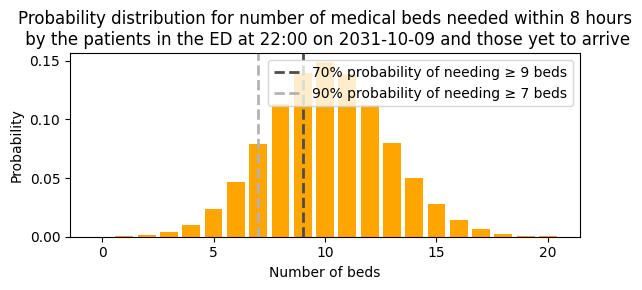

In [20]:
title = (
    f'Probability distribution for number of medical beds needed within {int(prediction_window.total_seconds()/3600)} hours\n'
    f' by the patients in the ED at {format_prediction_time(random_prediction_time)} '
    f'on {random_prediction_date} and those yet to arrive'
)

bundle = predictor.predict_service(
    inputs=prediction_inputs['medical'],
    flow_selection=FlowSelection.custom(
        include_ed_current=True,
        include_ed_yta=True, #only change is setting include_ed_yta to True
        include_non_ed_yta=False,
        include_elective_yta=False,
        include_transfers_in=False,
        include_departures=False,  # No departures
        cohort="emergency"
    ))
    
plot_prob_dist(bundle.arrivals.probabilities, title, 
    include_titles=True, truncate_at_beds=20,
    probability_levels=[0.7,0.9],
    show_probability_thresholds=True, bar_colour='orange')

## Real-time inference (legacy processing)

The legacy approach (the first version at UCLH) used a single function shown below for completeness.

In [27]:
from patientflow.predict.emergency_demand import create_predictions

create_predictions(
    models = (admission_model, spec_model, yta_model_by_spec),
    prediction_time = random_prediction_time,
    prediction_snapshots = prediction_snapshots_processed,
    specialties = ['medical', 'surgical', 'haem/onc', 'paediatric'],
    prediction_window = timedelta(hours=8),
    cdf_cut_points =  [0.7, 0.9], 
    x1 = x1,
    y1 = y1,
    x2 = x2, 
    y2 = y2)

{'medical': {'in_ed': [7, 5], 'yet_to_arrive': [1, 0]},
 'surgical': {'in_ed': [3, 1], 'yet_to_arrive': [0, 0]},
 'haem/onc': {'in_ed': [1, 0], 'yet_to_arrive': [0, 0]},
 'paediatric': {'in_ed': [1, 0], 'yet_to_arrive': [0, 0]}}

## 4. Make predictions using empirical survival curve

If your implementation does not use ED targets, the predictions can be generated using empirical data to calculate the probability that a patient to be admitted within the prediction window. 

First, I show how a survival curve would be used to calculate this probability of admission within the window. Then I re-implement the creation of predictions

In [22]:
## Add synthetic value for admitted_to_ward_datetime to the dataset, if not available

import numpy as np

if 'admitted_to_ward_datetime' not in train_inpatient_arrivals_df.columns:

    scale_hours = 12  # Average length of stay in hours
    length_of_stay_minutes = np.random.exponential(scale=scale_hours * 60, size=len(train_inpatient_arrivals_df))

    # Clip to reasonable bounds (1 hour minimum, 2 days maximum)
    length_of_stay_minutes = np.clip(length_of_stay_minutes, 0, 5 * 24 * 60)

    train_inpatient_arrivals_df['admitted_to_ward_datetime'] = [
        arrival + pd.Timedelta(minutes=los)
        for arrival, los in zip(train_inpatient_arrivals_df.index, length_of_stay_minutes)
    ]



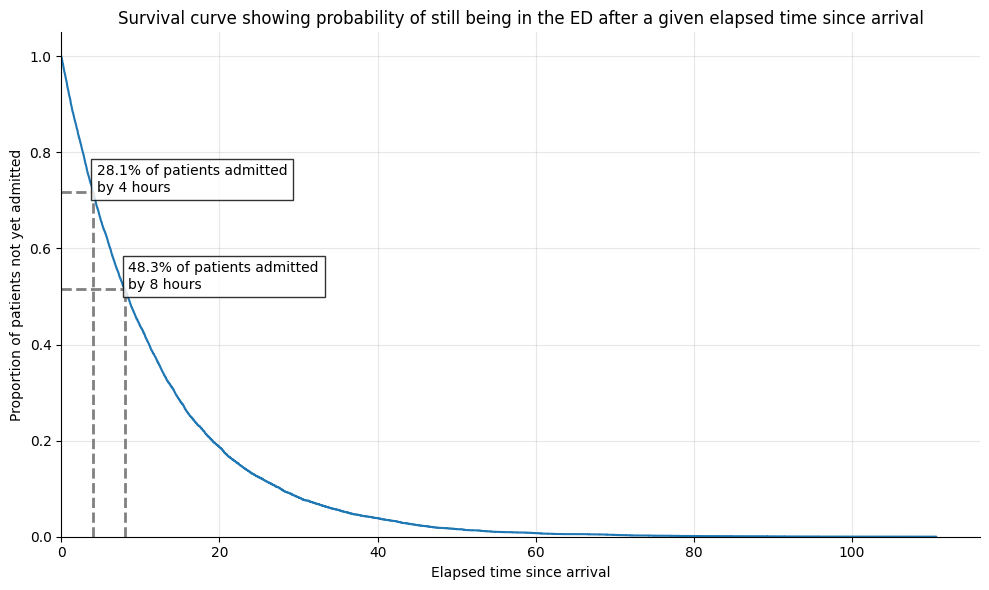

In [23]:
from patientflow.viz.survival_curve import plot_admission_time_survival_curve
title = 'Survival curve showing probability of still being in the ED after a given elapsed time since arrival'
survival_df = plot_admission_time_survival_curve(train_inpatient_arrivals_df.reset_index(), 
                                   start_time_col="arrival_datetime",
                                   end_time_col="admitted_to_ward_datetime",
                                   title=title,
                                   ylabel='Proportion of patients not yet admitted',
                                   xlabel='Elapsed time since arrival',
                                   target_hours=[4, 8],
                                   annotation_string="{:.1%} of patients admitted\nby {:.0f} hours",
                                   return_df=True,
                                   return_figure=False
)

`patientflow` includes a function to look up the probability of admission within a prediction window, using the survival curve. This is demonstrated below. It is used in the `create_predictions` function if the optional parameter `use_admission_in_window_prob` is set.

In [24]:
from patientflow.calculate.admission_in_prediction_window import calculate_admission_probability_from_survival_curve

prob_admission_in_window_from_survival_curve = calculate_admission_probability_from_survival_curve(
    elapsed_los = timedelta(hours=1), 
    prediction_window = prediction_window,
    survival_df = survival_df
)

print(f'Probability of admission in prediction window of {prediction_window.total_seconds() / 3600:.0f} hours, assuming patient has been in ED for 1 hour: {prob_admission_in_window_from_survival_curve:.2}')

Probability of admission in prediction window of 8 hours, assuming patient has been in ED for 1 hour: 0.48


For an array of patients, the probability of admission within the window would be created as shown below.

In [25]:
from patientflow.calculate.admission_in_prediction_window import calculate_admission_probability_from_survival_curve

# Calculate probability of admission within prediction window using ED targets
prob_admission_in_window_from_survival_curve = prediction_snapshots.apply(
    lambda row: calculate_admission_probability_from_survival_curve(
        elapsed_los = row["elapsed_los"], 
        prediction_window = prediction_window,
        survival_df = survival_df
    ),
    axis=1,
)


Predictions are created using the legacy appraoch. 


In [26]:
from patientflow.predict.emergency_demand import create_predictions
from patientflow.predictors.incoming_admission_predictors import EmpiricalIncomingAdmissionPredictor

# First I'll train the empirical yet-to-arrive model
train_inpatient_arrivals_df_copy = train_inpatient_arrivals_df.copy(deep=True)

num_days = (start_validation_set - start_training_set).days

# the arrival_datetime column needs to be set as the index of the dataframe
if 'arrival_datetime' in train_inpatient_arrivals_df_copy.columns:
    train_inpatient_arrivals_df_copy.set_index('arrival_datetime', inplace=True)

specialty_filters = filters={
    'medical': {'specialty': 'medical'},
    'surgical': {'specialty': 'surgical'},
    'haem/onc': {'specialty': 'haem/onc'},
    'paediatric': {'specialty': 'paediatric'}
    }

yta_model_by_spec_empirical =  EmpiricalIncomingAdmissionPredictor(filters = specialty_filters, verbose=False)
yta_model_by_spec_empirical.fit(train_inpatient_arrivals_df_copy, 
                        prediction_window=prediction_window, 
                        yta_time_interval=yta_time_interval, 
                        prediction_times=ed_visits.prediction_time.unique(), 
                        num_days=num_days,
                        start_time_col='arrival_datetime',
                        end_time_col='admitted_to_ward_datetime')

models = (admission_model, spec_model, yta_model_by_spec_empirical)

# convert elapsed_los to timedelta to ensure correct calculation of probability of admission within prediction window
prediction_snapshots['elapsed_los'] = pd.to_timedelta(prediction_snapshots['elapsed_los'], unit='s')

create_predictions(
    models = models,
    prediction_time = random_prediction_time,
    prediction_snapshots = prediction_snapshots,
    specialties = ['medical', 'surgical', 'haem/onc', 'paediatric'],
    prediction_window = prediction_window,
    cdf_cut_points =  [0.7, 0.9], 
    x1 = x1,
    y1 = y1,
    x2 = x2, 
    y2 = y2,
    use_admission_in_window_prob = True)

{'medical': {'in_ed': [3, 2], 'yet_to_arrive': [0, 0]},
 'surgical': {'in_ed': [1, 0], 'yet_to_arrive': [0, 0]},
 'haem/onc': {'in_ed': [0, 0], 'yet_to_arrive': [0, 0]},
 'paediatric': {'in_ed': [0, 0], 'yet_to_arrive': [0, 0]}}

## Summary

Here I have shown how `patientflow` is used at UCLH to generate predictions of emergency demand for beds in the next 8 hours. There are two elements to the predictions. 

* predictions for patients already in the ED
* predictions for patients yet-to-arrive to the ED, who will need admission in the next 8 hours

Both sets of predictions assume specified ED targets are met. 

I also showed an alternative approach, in which predictions used past data to calculate probability of admission within a prediction window; in this case no assumption is made about ED targets being met.

I showed a full step-through in code, and also two functions that you can use if your logic flow is similar to that at UCLH. 

In the next notebook, I show how to evaluate the predictions against the numbers of patients actually admitted. 